In [1]:
!pip install keras-tuner --quiet

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 4.7 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score, roc_curve,classification_report
from imblearn.over_sampling import SMOTE
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
import keras_tuner as kt
import warnings

In [3]:
credit_df = pd.read_csv('https://docs.google.com/spreadsheets/d/e/2PACX-1vTgfmZx-JNJNpxBSAqr-R2FI4TBqKa8Kpnv-4JzwAVXAqMn2eDNZFnB6UWf5nJNwFuiIkE38E-hVJGk/pub?gid=1661961097&single=true&output=csv')
credit_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 24 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   X1      30000 non-null  int64
 1   X2      30000 non-null  int64
 2   X3      30000 non-null  int64
 3   X4      30000 non-null  int64
 4   X5      30000 non-null  int64
 5   X6      30000 non-null  int64
 6   X7      30000 non-null  int64
 7   X8      30000 non-null  int64
 8   X9      30000 non-null  int64
 9   X10     30000 non-null  int64
 10  X11     30000 non-null  int64
 11  X12     30000 non-null  int64
 12  X13     30000 non-null  int64
 13  X14     30000 non-null  int64
 14  X15     30000 non-null  int64
 15  X16     30000 non-null  int64
 16  X17     30000 non-null  int64
 17  X18     30000 non-null  int64
 18  X19     30000 non-null  int64
 19  X20     30000 non-null  int64
 20  X21     30000 non-null  int64
 21  X22     30000 non-null  int64
 22  X23     30000 non-null  int64
 23  y       300

In [4]:
percent_missing = (credit_df.isnull().sum() / credit_df.shape[0]) * 100
print(percent_missing)

X1     0.0
X2     0.0
X3     0.0
X4     0.0
X5     0.0
X6     0.0
X7     0.0
X8     0.0
X9     0.0
X10    0.0
X11    0.0
X12    0.0
X13    0.0
X14    0.0
X15    0.0
X16    0.0
X17    0.0
X18    0.0
X19    0.0
X20    0.0
X21    0.0
X22    0.0
X23    0.0
y      0.0
dtype: float64


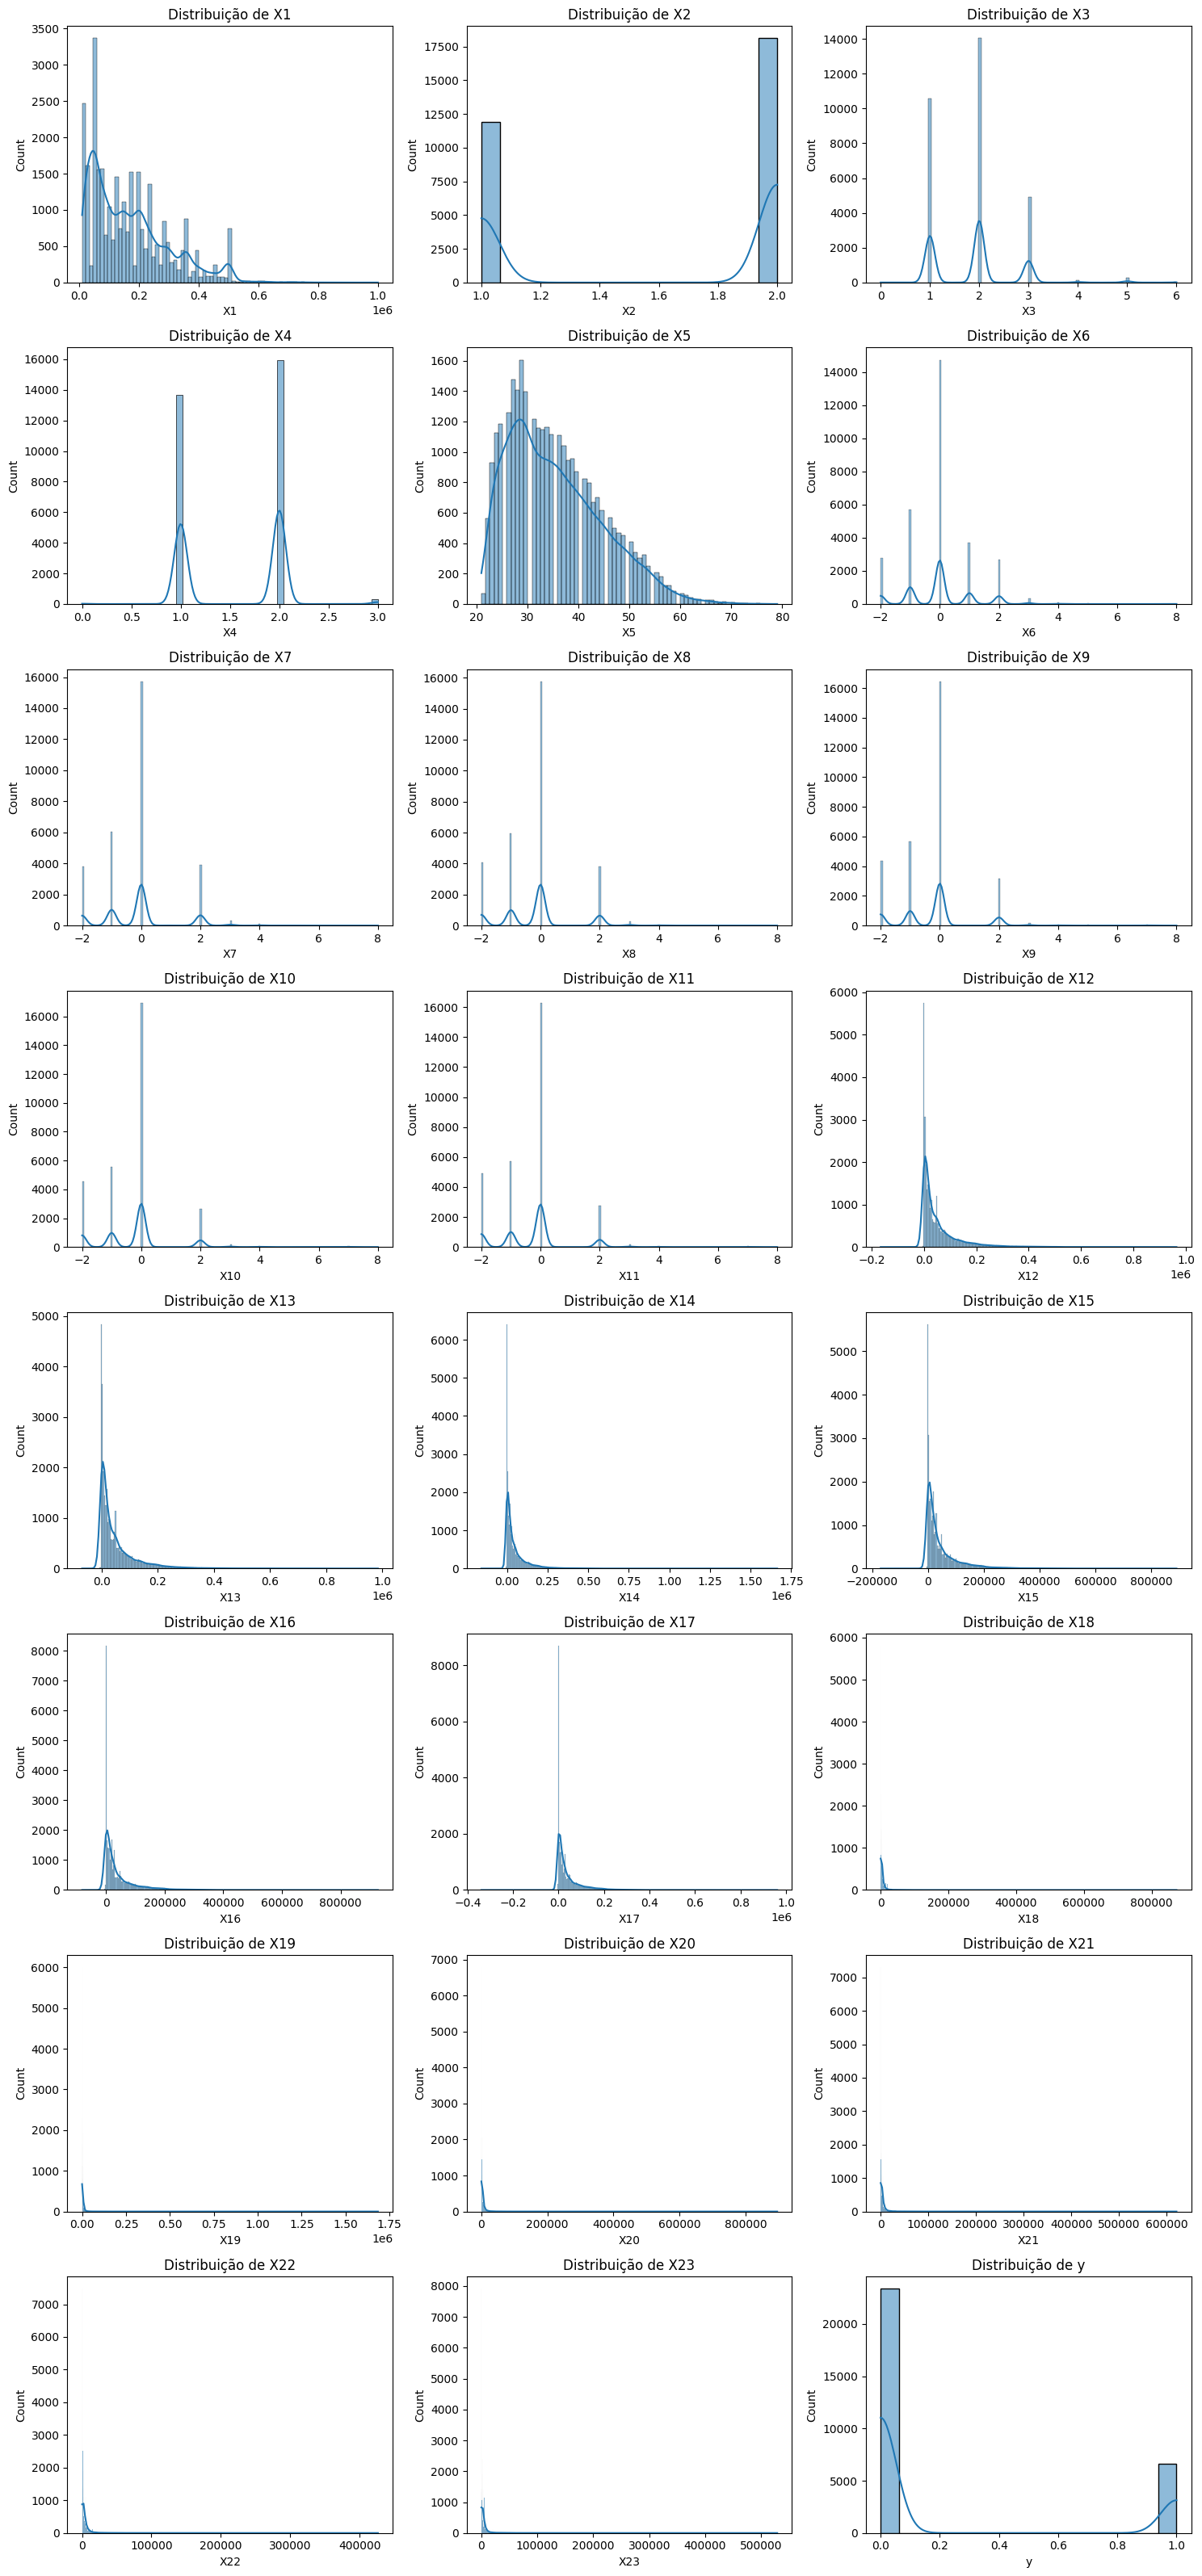

In [5]:
# Grafico de distribuição das notas de qualidade

num_colunas = len(credit_df.columns)

# Calcular número de linhas necessário (supondo 3 colunas por linha)
num_linhas = math.ceil(num_colunas / 3)

# Criar a figura
plt.figure(figsize=(15, num_linhas * 4))

# Criar os subplots
for i, col in enumerate(credit_df.columns, 1):
    if i > 30:
        break  # Limitar a 15 gráficos

    plt.subplot(num_linhas, 3, i)  # Ajuste dinâmico
    sns.histplot(credit_df[col], kde=True)
    plt.title(f'Distribuição de {col}')

plt.tight_layout()
plt.show()


In [13]:

warnings.filterwarnings("ignore")

def run_mlp_model(df, target_column, balance_data=True):
    print("Iniciando pipeline MLP com autoajuste...\n")

    # 1. Tratamento de nulos
    for col in df.columns:
        if df[col].dtype == 'object':
            df[col] = df[col].fillna('não informado')
        else:
            df[col] = df[col].fillna(df[col].median())

    # 2. Label Encoding
    df_encoded = df.copy()
    le = LabelEncoder()
    for col in df_encoded.select_dtypes(include='object').columns:
        df_encoded[col] = le.fit_transform(df_encoded[col].astype(str))

    # 3. X e y
    X = df_encoded.drop(columns=[target_column])
    y = df_encoded[target_column]

    # 4. Tipo de tarefa
    n_classes = len(np.unique(y))
    task_type = 'binária' if n_classes == 2 else 'multiclasse'
    print(f"Tipo de tarefa detectado: Classificação {task_type} ({n_classes} classes)")

    # 5. Escalonamento
    scaler = MinMaxScaler()
    X_scaled = scaler.fit_transform(X)

    # 6. SMOTE
    if balance_data:
        print("Aplicando SMOTE para balanceamento...")
        smote = SMOTE(random_state=42)
        X_scaled, y = smote.fit_resample(X_scaled, y)

    # 7. Treino/Teste
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, stratify=y, random_state=42)

    # 8. One-hot
    y_train_cat = to_categorical(y_train)
    y_test_cat = to_categorical(y_test)

    # 9. Modelo com KerasTuner
    def build_model(hp):
        model = Sequential()
        model.add(Dense(units=hp.Int('input_units', 32, 128, step=32), activation='relu', input_shape=(X_train.shape[1],)))
        model.add(BatchNormalization())
        model.add(Dropout(hp.Float('dropout1', 0.1, 0.5, step=0.1)))

        for i in range(hp.Int('n_layers', 1, 3)):
            model.add(Dense(units=hp.Int(f'units_{i}', 32, 128, step=32), activation='relu'))
            model.add(Dropout(hp.Float(f'dropout_{i}', 0.1, 0.5, step=0.1)))

        model.add(Dense(n_classes, activation='softmax'))
        model.compile(
            optimizer=Adam(learning_rate=hp.Choice('lr', [1e-2, 1e-3, 1e-4])),
            loss='categorical_crossentropy',
            metrics=['categorical_accuracy']
        )
        return model

    tuner = kt.RandomSearch(
        build_model,
        objective='val_categorical_accuracy',
        max_trials=5,
        directory='mlp_tuning',
        project_name='mlp_auto'
    )

    early = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

    print("\nBuscando melhor modelo...")
    tuner.search(X_train, y_train_cat, epochs=100, validation_split=0.3, callbacks=[early], verbose=0)
    best_model = tuner.get_best_models(num_models=1)[0]

    # 10. Avaliação
    print("\nAvaliando modelo final na base de teste...")
    _, acc = best_model.evaluate(X_test, y_test_cat, verbose=0)
    print(f"Acurácia final: {acc:.4f}")

    # 11. Previsões
    y_pred = np.argmax(best_model.predict(X_test), axis=1)
    print("\nRelatório de Classificação:\n", classification_report(y_test, y_pred))

    # 12. Matriz de Confusão Absoluta
    cm = confusion_matrix(y_test, y_pred)
    print("Matriz de Confusão (valores absolutos):\n", cm)

    plt.figure(figsize=(6,4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão - Absoluta')
    plt.tight_layout()
    plt.show()

    # 13. Matriz de Confusão Percentual
    cm_percent = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    plt.figure(figsize=(6,4))
    sns.heatmap(cm_percent, annot=True, fmt='.2%', cmap='Greens', cbar=False)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title('Matriz de Confusão - Percentual')
    plt.tight_layout()
    plt.show()

    # 14. Curva ROC
    if n_classes == 2:
        y_proba = best_model.predict(X_test)[:, 1]
        auc = roc_auc_score(y_test, y_proba)
        fpr, tpr, _ = roc_curve(y_test, y_proba)
        plt.figure(figsize=(8,5))
        plt.plot(fpr, tpr, label=f'MLP (AUC = {auc:.2f})')
        plt.plot([0,1], [0,1], 'k--')
        plt.title('Curva ROC - Classificação Binária')
        plt.xlabel('FPR')
        plt.ylabel('TPR')
        plt.legend()
        plt.grid()
        plt.show()

    print("Pipeline finalizado com sucesso!")

Iniciando pipeline MLP com autoajuste...

Tipo de tarefa detectado: Classificação binária (2 classes)
Aplicando SMOTE para balanceamento...
Reloading Tuner from mlp_tuning/mlp_auto/tuner0.json

Buscando melhor modelo...

Avaliando modelo final na base de teste...
Acurácia final: 0.7142
293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 929us/step

Relatório de Classificação:
               precision    recall  f1-score   support

           0       0.68      0.82      0.74      4673
           1       0.77      0.61      0.68      4673

    accuracy                           0.71      9346
   macro avg       0.72      0.71      0.71      9346
weighted avg       0.72      0.71      0.71      9346

Matriz de Confusão (valores absolutos):
 [[3829  844]
 [1827 2846]]


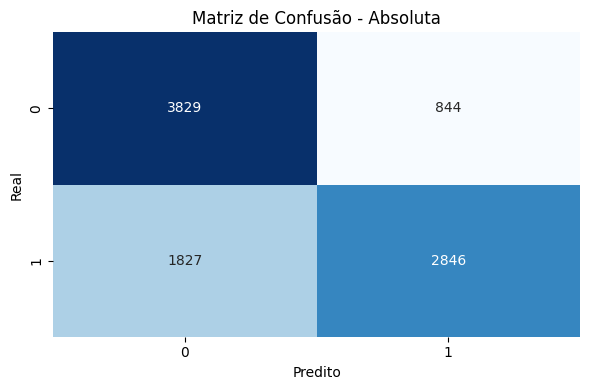

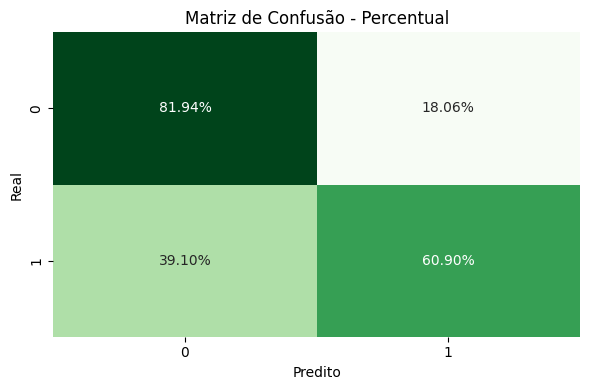

293/293 ━━━━━━━━━━━━━━━━━━━━ 0s 774us/step


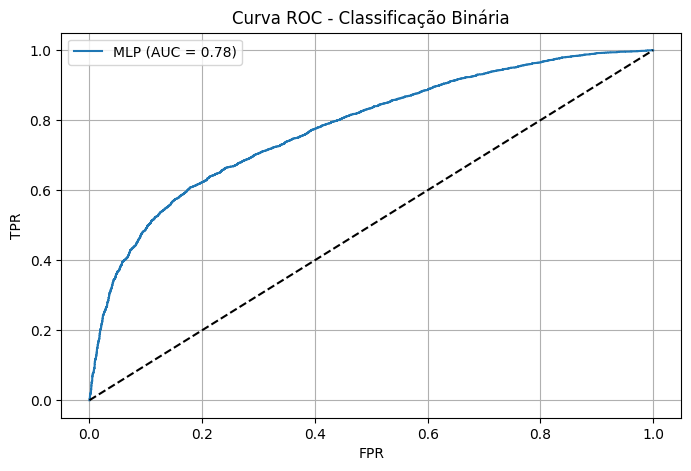

Pipeline finalizado com sucesso!


In [14]:
run_mlp_model(credit_df, target_column='y')

In [15]:
from sklearn.neighbors import KNeighborsClassifier,KNeighborsRegressor
from sklearn.linear_model import LogisticRegression,LinearRegression
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

In [10]:
# Transformando em X e y passando o Treinamento

X = credit_df.drop(columns=['y'], axis=1)
y = credit_df['y']

# Normalizar X
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Dividindo os dados em conjuntos de treino e teste 80 para treino e 20 para teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Testar diferentes valores de K para o KNN Classificador
k_values = range(1, 21)
accuracies = []

for k in k_values:
    modelo = KNeighborsClassifier(n_neighbors=k)
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)

# Melhor K para classificação
melhor_k = k_values[np.argmax(accuracies)]

# Modelos de Classificação
modelos_clf = [
    ('Regressão Logística', LogisticRegression(max_iter=1000)),
    ('Árvore de Decisão', DecisionTreeClassifier(random_state=42)),
    ('Random Forest', RandomForestClassifier(n_estimators=100, random_state=42)),
    ('KNN', KNeighborsClassifier(n_neighbors=melhor_k))
]

# Avaliação dos modelos de Classificação
resultados_clf = []
for nome, modelo in modelos_clf:
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    acuracia = accuracy_score(y_test, y_pred) * 100
    precisao = precision_score(y_test, y_pred, average='macro', zero_division=1) * 100
    recall = recall_score(y_test, y_pred, average='macro', zero_division=1) * 100
    f1 = f1_score(y_test, y_pred, average='macro', zero_division=1) * 100

    resultados_clf.append((nome, acuracia, precisao, recall, f1))

# Ordenar os resultados por F1-score
resultados_clf_ordenados = sorted(resultados_clf, key=lambda x: x[1], reverse=True)

# Exibir os resultados da Classificação
print("\n📊 Resultados - Modelos de Classificação Credit card:")
print(f"{'Modelo':<25} {'Acurácia':<10} {'Precisão':<10} {'Recall':<10} {'F1-Score':<10}")
for nome, acuracia, precisao, recall, f1 in resultados_clf_ordenados:
    print(f"{nome:<25} {acuracia:.2f}%    {precisao:.2f}%    {recall:.2f}%    {f1:.2f}%")

# Agora para os modelos de Regressão
y_reg = credit_df['y']  # Usamos a qualidade como valor contínuo

# Divisão treino/teste para regressão
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y_reg, test_size=0.2, random_state=42)

# Modelos de Regressão
modelos_reg = [
    ('Linear', LinearRegression()),
    ('Árvore de Decisão ', DecisionTreeRegressor(random_state=42)),
    ('Random Forest', RandomForestRegressor(n_estimators=100, random_state=42)),
    ('KNN ', KNeighborsRegressor(n_neighbors=melhor_k))
]

# Avaliação dos modelos de Regressão
resultados_reg = []
media_y_test = np.mean(y_test)  # Média de y_test para normalizar os erros

for nome, modelo in modelos_reg:
    modelo.fit(X_train, y_train)
    y_pred = modelo.predict(X_test)

    mae = (mean_absolute_error(y_test, y_pred) / media_y_test) * 100
    mse = (mean_squared_error(y_test, y_pred) / media_y_test) * 100
    r2 = r2_score(y_test, y_pred) * 100  # Já está normalizado, apenas convertendo para %

    resultados_reg.append((nome, mae, mse, r2))

# Ordenar os resultados da regressão pelo menor MAE
resultados_reg_ordenados = sorted(resultados_reg, key=lambda x: x[3])

# Exibir os resultados da Regressão
print("\n📊 Resultados - Modelos de Regressão Credit Card:")
print(f"{'Modelo':<30} {'MAE (%)':<10} {'MSE (%)':<10} {'R² (%)':<10}")
for nome, mae, mse, r2 in resultados_reg_ordenados:
    print(f"{nome:<30} {mae:.2f}%    {mse:.2f}%    {r2:.2f}%")


📊 Resultados - Modelos de Classificação Credit card:
Modelo                    Acurácia   Precisão   Recall     F1-Score  
Random Forest             81.60%    73.99%    65.47%    67.77%
Regressão Logística       80.17%    73.32%    58.47%    59.46%
KNN                       78.00%    63.77%    52.86%    50.67%
Árvore de Decisão         72.55%    60.59%    61.10%    60.82%

📊 Resultados - Modelos de Regressão Credit Card:
Modelo                         MAE (%)    MSE (%)    R² (%)    
Árvore de Decisão              127.05%    126.96%    -62.52%
Linear                         140.09%    68.85%    11.86%
KNN                            124.51%    65.51%    16.14%
Random Forest                  126.42%    64.45%    17.50%
